In [1]:
import os
import sys
from typing import List, Tuple, Optional, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import yaml
from pathlib import Path
import rasterio
import random
from glob import glob

from util.datasets import SentinelIndividualImageDataset, SentinelNormalize
from util.misc import load_model
from models_cae import cae_vit_base_patch16
from models_mae import mae_vit_base_patch16

device = torch.cuda.is_available() and 'cuda' or 'cpu'
device

'cuda'

# Get Samples

In [2]:
def load_satellite_images(image_dir: str, n_samples: int = 2, 
                         red_band: int = 4, green_band: int = 3, blue_band: int = 2) -> List[np.ndarray]:
    """
    Load RGB composites from satellite imagery TIFF files.
    
    Args:
        image_dir: Directory containing TIFF files
        n_samples: Number of random images to load
        red_band: Band number for red channel (1-based indexing)
        green_band: Band number for green channel
        blue_band: Band number for blue channel
    
    Returns:
        List of numpy arrays with shape (H, W, 3) containing normalized RGB images
    """
    # Get all tiff files in directory
    tiff_files = glob(os.path.join(image_dir, "*.tif"))
    
    if not tiff_files:
        raise ValueError(f"No TIFF files found in {image_dir}")
    
    # Randomly select n files
    selected_files = random.sample(tiff_files, min(n_samples, len(tiff_files)))
    
    images = []
    filenames = []
    
    red_band, green_band, blue_band = 4, 3, 2
    
    for file_path in selected_files:
        with rasterio.open(file_path) as src:
            # Read the specified bands (adjusting for 0-based indexing)
            r = src.read(red_band)
            g = src.read(green_band)
            b = src.read(blue_band)
            
            # Stack bands and normalize
            rgb = np.stack([r, g, b], axis=-1)
            rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())
            
            images.append(rgb_norm)
            filenames.append(os.path.basename(file_path))
    
    return images, filenames

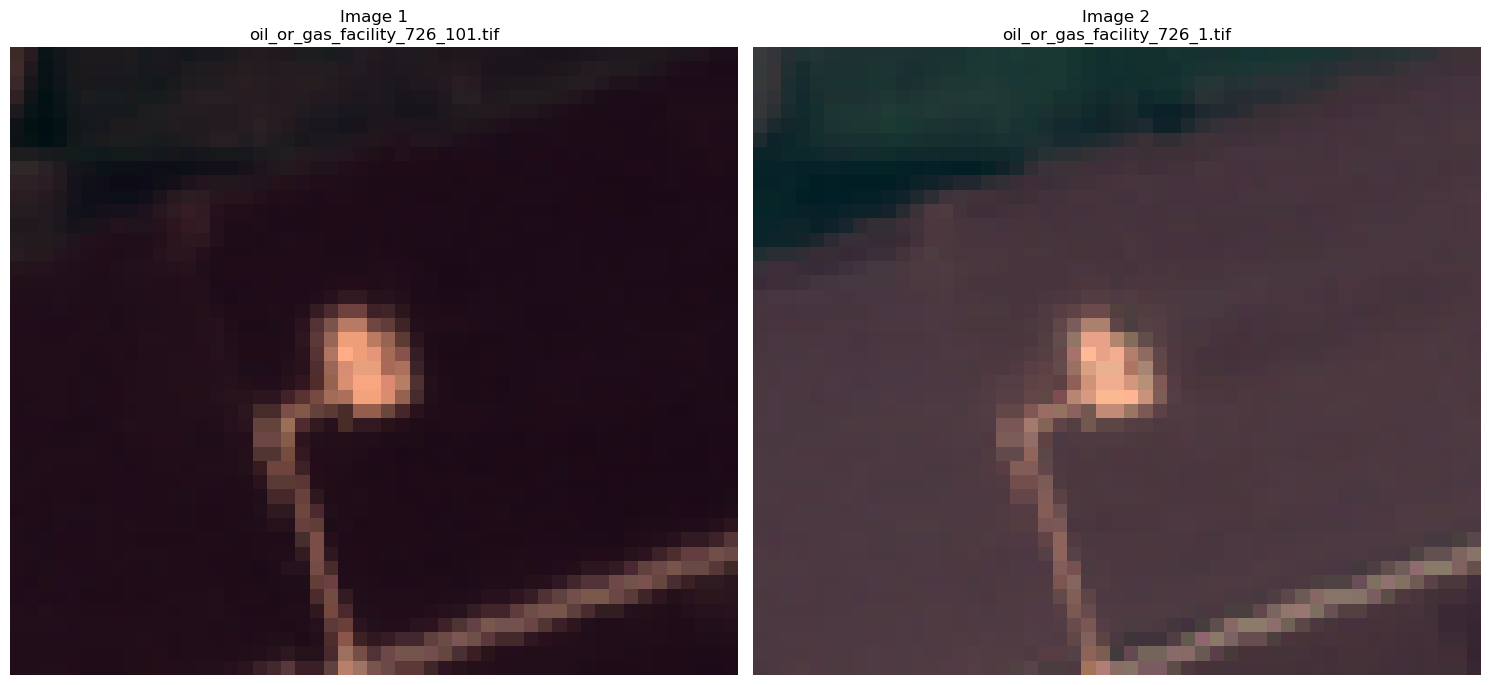

In [3]:
# image_dir = "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/train/airport/airport_0"
# image_dir = "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/val/shipyard/shipyard_1"
image_dir = "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/train/oil_or_gas_facility/oil_or_gas_facility_726"
# 726


images, filenames = load_satellite_images(image_dir, n_samples=2)

fig, axes = plt.subplots(1, len(images), figsize=(15, 7))
if len(images) == 1:
    axes = [axes]

for idx, (img, fname) in enumerate(zip(images, filenames)):
    axes[idx].imshow(images[idx])
    axes[idx].set_title(f'Image {idx+1}\n{fname}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [105]:
csv_path = "/home/ubuntu/satellite-cae/SatMAE/data/sampled_by_location.csv"

mean = SentinelIndividualImageDataset.mean
std = SentinelIndividualImageDataset.std
transform = SentinelIndividualImageDataset.build_transform(
    is_train=False, input_size=224, mean=mean, std=std
)
dataset = SentinelIndividualImageDataset(
    csv_path=csv_path,
    transform=transform
)

batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

batch <class 'torch.Tensor'>
torch.Size([13, 224, 224])
torch.Size([13, 224, 224])
torch.Size([13, 224, 224])
torch.Size([13, 224, 224])


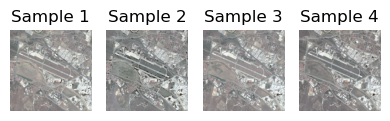

In [107]:
# Get one batch of samples
batch, _ = next(iter(dataloader))
print(f"batch {type(batch)}")

# Display the samples using bands 4,3,2 for RGB
fig, axes = plt.subplots(1, batch_size, figsize=(4, 4))
if batch_size == 1:
    axes = [axes]

for idx in range(batch_size):
    sample = batch[idx]  # Get individual sample from the list
    print(sample.shape)
    # The tensor has shape [1, 13, 224, 224], we need to squeeze out the first dimension
    sample = sample.squeeze(0)  # Now should be [13, 224, 224]
    
    # Extract bands 4,3,2 (indices 3,2,1 due to 0-based indexing)
    rgb = sample[[3,2,1]].numpy()  # Select bands
    rgb = np.transpose(rgb, (1, 2, 0))  # Change to (H, W, C) for plotting
    
    # Normalize for visualization
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    
    axes[idx].imshow(rgb_norm)
    axes[idx].set_title(f'Sample {idx+1}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Utils

In [36]:
def run_inference(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Run inference on the model and return reconstructions
    """
    model.eval()
    with torch.no_grad():
        # Get a batch of samples
        batch, _ = next(iter(dataloader))
        # Move samples to the same device as model
        batch = batch.to(device)
        
        out = model(batch)
        if len(out) == 5:
            loss, _, _, reconstructions, mask = model(batch)
        else:
            loss, reconstructions, mask = model(batch)
        
        return batch, model.unpatchify(reconstructions, p=16, c=13), mask

def load_and_transform_img(img_path, input_size=224):
        mean = [1370.19151926, 1184.3824625 , 1120.77120066, 1136.26026392,
                1263.73947144, 1645.40315151, 1846.87040806, 1762.59530783,
                1972.62420416,  582.72633433,   14.77112979, 1732.16362238, 1247.91870117]
        std = [633.15169573,  650.2842772 ,  712.12507725,  965.23119807,
               948.9819932 , 1108.06650639, 1258.36394548, 1233.1492281 ,
               1364.38688993,  472.37967789,   14.3114637 , 1310.36996126, 1087.6020813]
    
        if input_size <= 224:
            crop_pct = 224 / 256
        else:
            crop_pct = 1.0
        size = int(input_size / crop_pct)
        
        t = []
        t.append(SentinelNormalize(mean, std))
        t.append(transforms.ToTensor())
        t.append(
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))
        t = transforms.Compose(t)
        
        with rasterio.open(img_path) as data:
            img = data.read()  # (c, h, w)

        img = img.transpose(1, 2, 0).astype(np.float32) 
        
        return t(img)
    
def run_inference_single_image(model, image_path, device="cuda"):
    """
    Run inference on a single image
    """
    model.eval()
    with torch.no_grad():
        # Preprocess the image
        
        img_tensor = load_and_transform_img(image_path)
        img_tensor = img_tensor.unsqueeze(0)
        # Move to device
        img_tensor = img_tensor.to(device)
        
        # Run inference
        out = model(img_tensor)
        if len(out) == 5:
            loss, _, _, reconstructions, mask = model(img_tensor)
        else:
            loss, reconstructions, mask = model(img_tensor)
        
        return img_tensor, model.unpatchify(reconstructions, p=16, c=13)
    
def visualize_reconstruction(original, reconstruction, sample_idx=0):
    """
    Visualize the original and reconstructed images side by side
    Using bands 4,3,2 for RGB visualization
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Process original image
    orig_rgb = original[sample_idx].squeeze(0)[[3,2,1]].cpu().numpy()
    print(f"orig_rgb {orig_rgb.shape}")
    orig_rgb = np.transpose(orig_rgb, (1, 2, 0))
    orig_rgb = (orig_rgb - orig_rgb.min()) / (orig_rgb.max() - orig_rgb.min())
    
    # Process reconstructed image
    recon_rgb = reconstruction[sample_idx].squeeze(0)[[3,2,1]].cpu().numpy()
    print(f"recon_rgb {recon_rgb.shape}")
    recon_rgb = np.transpose(recon_rgb, (1, 2, 0))
    recon_rgb = (recon_rgb - recon_rgb.min()) / (recon_rgb.max() - recon_rgb.min())
    
    ax1.imshow(orig_rgb)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(recon_rgb)
    ax2.set_title('Reconstructed')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def visualize_reconstruction_(original, mask, reconstruction, sample_idx=0, patch_size=16):
    """
    Visualize the original, masked, and reconstructed images side by side
    Using bands 4,3,2 for RGB visualization
    
    Args:
        original: Original input image
        mask: Binary mask of shape (num_patches_h, num_patches_w) where 1=masked, 0=unmasked
        reconstruction: Reconstructed image from the autoencoder
        sample_idx: Index of the sample to visualize (default: 0)
        patch_size: Size of patches used in masking (default: 16)
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Process original image
    orig_rgb = original[sample_idx].squeeze(0)[[3,2,1]].cpu().numpy()
    print("--------------", orig_rgb.shape)
    print(f"orig_rgb {orig_rgb.shape}")
    orig_rgb = np.transpose(orig_rgb, (1, 2, 0))
    orig_rgb = (orig_rgb - orig_rgb.min()) / (orig_rgb.max() - orig_rgb.min())
    
    # Create masked version using the patch mask
    masked_rgb = orig_rgb.copy()
    h, w = mask.shape
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 1:  # if patch is masked
                masked_rgb[i*patch_size:(i+1)*patch_size, 
                         j*patch_size:(j+1)*patch_size, :] = 0  # or another value to represent masking
    
    # Process reconstructed image
    recon_rgb = reconstruction[sample_idx].squeeze(0)[[3,2,1]].cpu().numpy()
    print(f"recon_rgb {recon_rgb.shape}")
    recon_rgb = np.transpose(recon_rgb, (1, 2, 0))
    recon_rgb = (recon_rgb - recon_rgb.min()) / (recon_rgb.max() - recon_rgb.min())
    
    # Plot the images
    ax1.imshow(orig_rgb)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(masked_rgb)
    ax2.set_title(f'Masked ({mask.sum()}/{mask.size} patches)')
    ax2.axis('off')
    
    ax3.imshow(recon_rgb)
    ax3.set_title('Reconstructed')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print masking ratio
    print(f"Masking ratio: {mask.sum() / mask.size:.2%}")

# CAE

## Load Model

In [7]:
cae = cae_vit_base_patch16(in_chans=13)
cae.to(device)

checkpoint_path = "/home/ubuntu/checkpoint-98.pth"
# checkpoint_path = "/home/ubuntu/satellite-cae/SatMAE/output_dir/checkpoint-0.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu')
cae.load_state_dict(checkpoint['model'], strict=False)

/tmp/ipykernel_6533/4194983178.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


_IncompatibleKeys(missing_keys=['teacher.0.norm1.weight', 'teacher.0.norm1.bias', 'teacher.0.attn.qkv.weight', 'teacher.0.attn.qkv.bias', 'teacher.0.attn.proj.weight', 'teacher.0.attn.proj.bias', 'teacher.0.norm2.weight', 'teacher.0.norm2.bias', 'teacher.0.mlp.fc1.weight', 'teacher.0.mlp.fc1.bias', 'teacher.0.mlp.fc2.weight', 'teacher.0.mlp.fc2.bias', 'teacher.1.norm1.weight', 'teacher.1.norm1.bias', 'teacher.1.attn.qkv.weight', 'teacher.1.attn.qkv.bias', 'teacher.1.attn.proj.weight', 'teacher.1.attn.proj.bias', 'teacher.1.norm2.weight', 'teacher.1.norm2.bias', 'teacher.1.mlp.fc1.weight', 'teacher.1.mlp.fc1.bias', 'teacher.1.mlp.fc2.weight', 'teacher.1.mlp.fc2.bias', 'teacher.2.norm1.weight', 'teacher.2.norm1.bias', 'teacher.2.attn.qkv.weight', 'teacher.2.attn.qkv.bias', 'teacher.2.attn.proj.weight', 'teacher.2.attn.proj.bias', 'teacher.2.norm2.weight', 'teacher.2.norm2.bias', 'teacher.2.mlp.fc1.weight', 'teacher.2.mlp.fc1.bias', 'teacher.2.mlp.fc2.weight', 'teacher.2.mlp.fc2.bias', 't

## Reconstruct

mask shape torch.Size([14, 14])
----------------------------Cae--------------------------------------------
reconstructions shape torch.Size([1, 13, 224, 224])
-------------- (3, 224, 224)
orig_rgb (3, 224, 224)
recon_rgb (3, 224, 224)


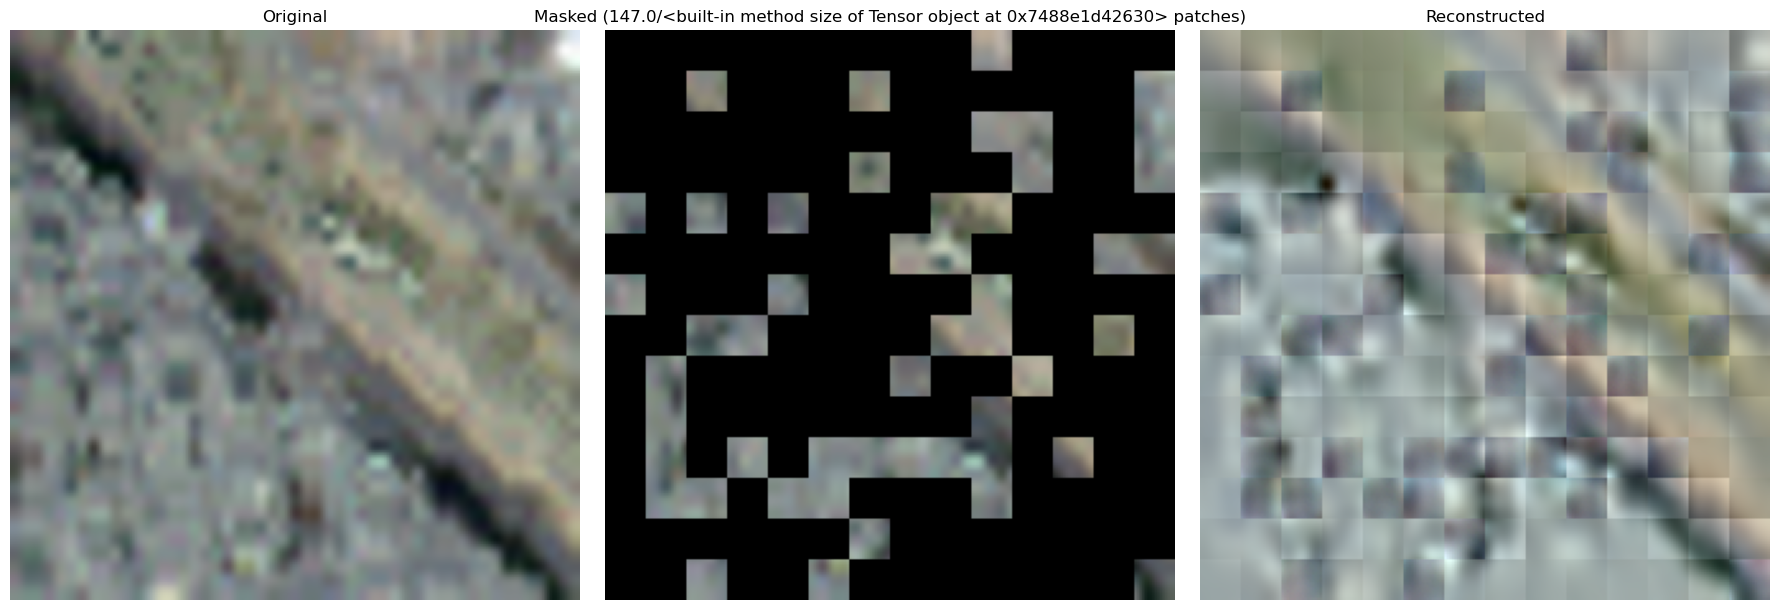

TypeError: unsupported operand type(s) for /: 'Tensor' and 'builtin_function_or_method'

In [130]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)
dt=dataloader
samples, reconstructions, mask = run_inference(cae, dataloader, device)
mask = mask.reshape((14, 14))
print(f"mask shape {mask.shape}")
print("----------------------------Cae--------------------------------------------")
print(f"reconstructions shape {reconstructions.shape}")

visualize_reconstruction_(samples, mask, reconstructions)


# MAE

In [137]:
mae = mae_vit_base_patch16(in_chans=13)
mae.to(device)

checkpoint_path = "/home/ubuntu/checkpoint-100.pth"
# checkpoint_path = "/home/ubuntu/satellite-cae/SatMAE/output_dir/checkpoint-satmae-99.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu')
mae.load_state_dict(checkpoint['model'], strict=False)

/tmp/ipykernel_6533/1869589092.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


<All keys matched successfully>

reconstructions shape torch.Size([1, 13, 224, 224])
-------------- (3, 224, 224)
orig_rgb (3, 224, 224)
recon_rgb (3, 224, 224)


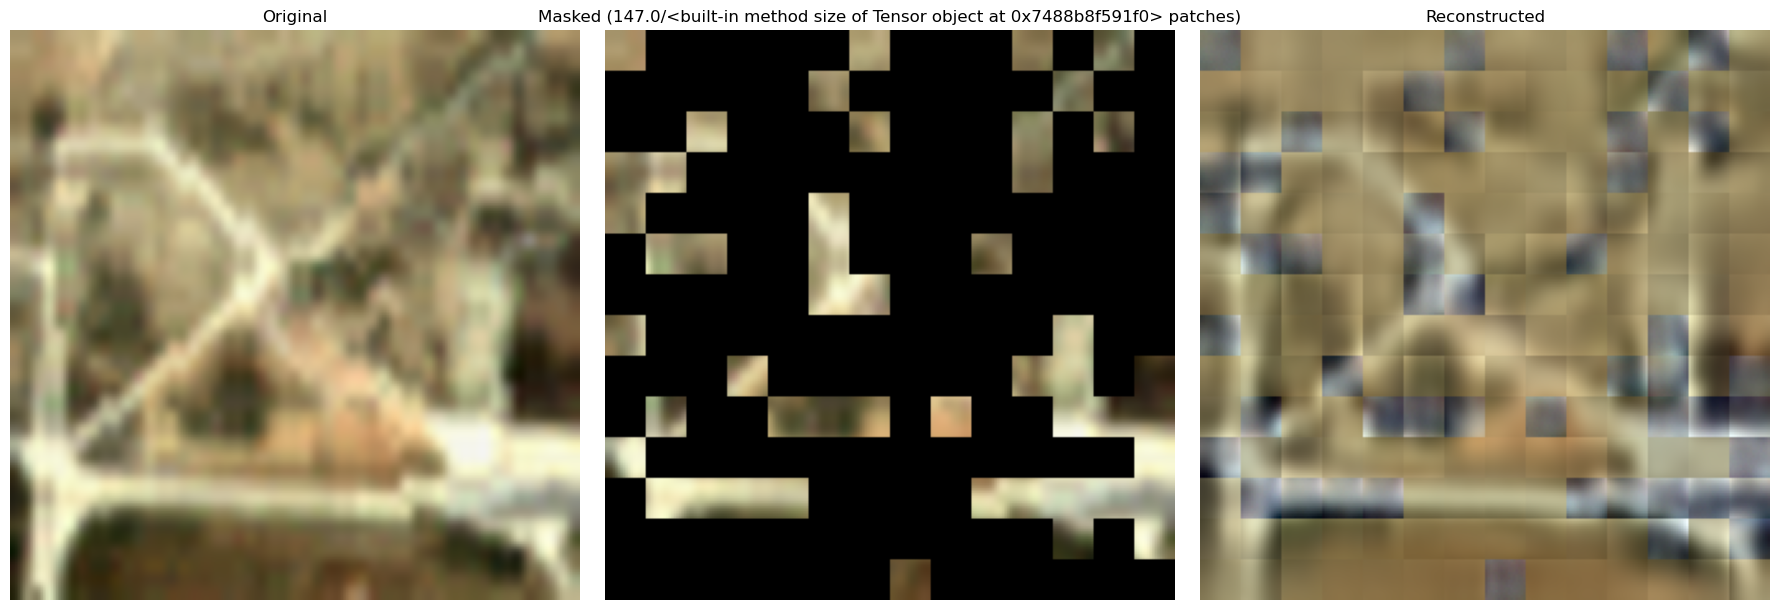

TypeError: unsupported operand type(s) for /: 'Tensor' and 'builtin_function_or_method'

In [160]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)
samples, reconstructions, mask = run_inference(mae, dataloader, device)
mask = mask.reshape((14, 14))
# samples, reconstructions = run_inference_single_image(mae, "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/val/shipyard/shipyard_1/shipyard_1_9.tif", device)
print(f"reconstructions shape {reconstructions.shape}")

visualize_reconstruction_(samples, mask, reconstructions)

********************* /home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/val/shipyard/shipyard_1/shipyard_1_9.tif
reconstructions shape torch.Size([1, 13, 224, 224])
-------------- (3, 224, 224)
orig_rgb (3, 224, 224)
recon_rgb (3, 224, 224)


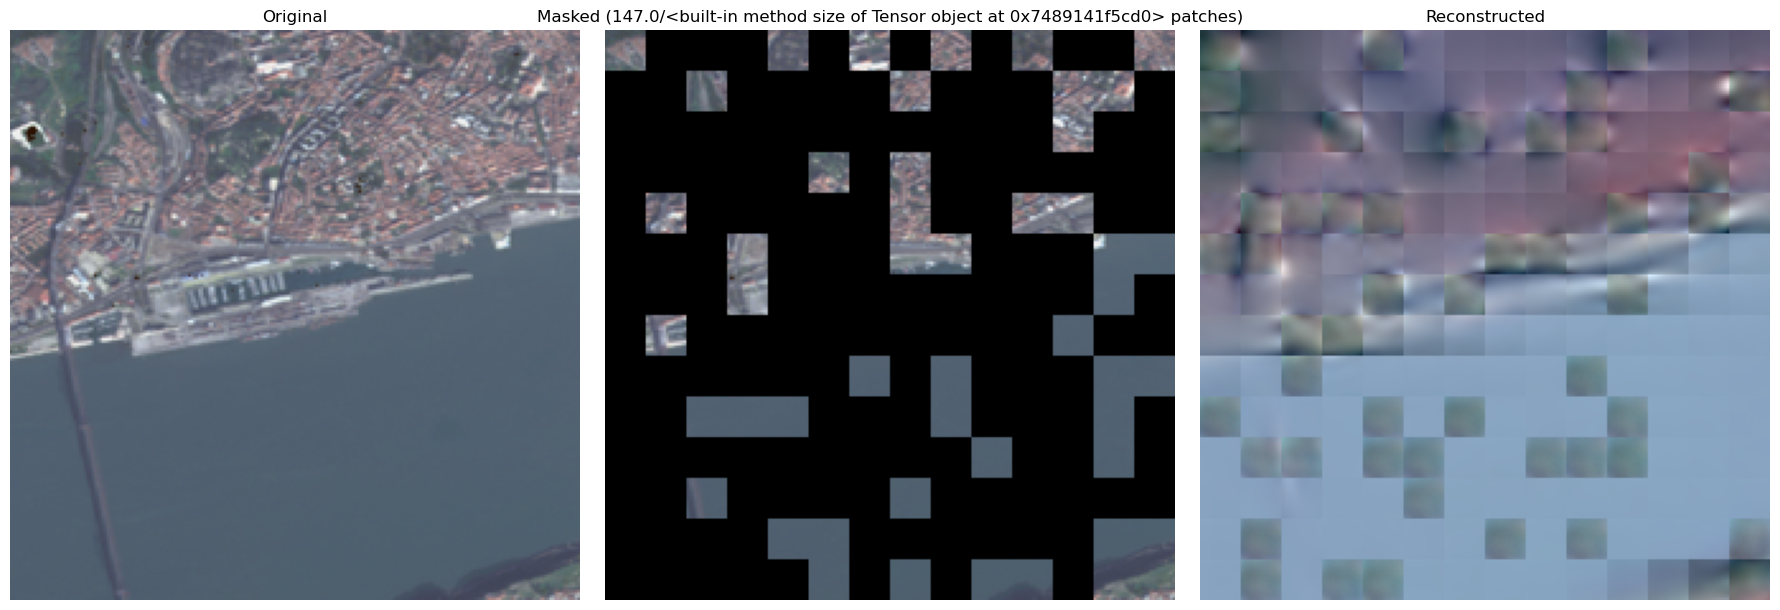

TypeError: unsupported operand type(s) for /: 'Tensor' and 'builtin_function_or_method'

In [134]:
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# samples, reconstructions, mask = run_inference(mae, dataloader, device)
# mask = mask.reshape((14, 14))
samples, reconstructions = run_inference_single_image(cae, "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/val/shipyard/shipyard_1/shipyard_1_9.tif", device)
print(f"reconstructions shape {reconstructions.shape}")

visualize_reconstruction_(samples, mask, reconstructions)


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def resize_and_visualize(image_path):
    # Load the TIFF image
    original = Image.open(image_path)
    
    # Define transforms
    to_tensor = transforms.ToTensor()
    resize_96 = transforms.Resize((96, 96), interpolation=transforms.InterpolationMode.BICUBIC)
    resize_224 = transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC)
    
    # Convert to tensor and apply transformations
    img_tensor = to_tensor(original)
    
    # First resize to 96x96
    img_96 = resize_96(img_tensor)
    
    # Then resize to 224x224
    img_224 = resize_224(img_96)
    
    # Convert tensors back to PIL images for visualization
    to_pil = transforms.ToPILImage()
    img_96_pil = to_pil(img_96)
    img_224_pil = to_pil(img_224)
    
    # Create figure for visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot images
    axes[0].imshow(original)
    axes[0].set_title(f'Original {original.size}')
    axes[0].axis('off')
    
    axes[1].imshow(img_96_pil)
    axes[1].set_title('Resized to 96x96')
    axes[1].axis('off')
    
    axes[2].imshow(img_224_pil)
    axes[2].set_title('Resized to 224x224')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Return tensors for further use if needed
    return img_tensor, img_96, img_224

# Example usage:
image_path = "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/val/shipyard/shipyard_1/shipyard_1_9.tif"
original_tensor, resized_96, resized_224 = resize_and_visualize(image_path)

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import rasterio
import numpy as np

def resize_and_visualize(tiff_path):
    # Load TIFF using rasterio
    with rasterio.open(tiff_path) as src:
        # Read all bands and combine into a single array
        image = src.read()  # Shape: (channels, height, width)
        
    # Convert to torch tensor
    img_tensor = torch.from_numpy(image).float()
    
    # Define resize transforms
    resize_96 = transforms.Resize((96, 96), interpolation=transforms.InterpolationMode.BICUBIC)
    resize_224 = transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC)
    
    # First resize to 96x96
    img_96 = resize_96(img_tensor)
    
    # Then resize to 224x224
    img_224 = resize_224(img_96)
    
    # Create figure for visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot images - assuming single band or taking first band for visualization
    # Normalize each image for better visualization
    def normalize_for_display(tensor):
        tensor_np = tensor.numpy()
        if tensor_np.ndim == 3:
            tensor_np = tensor_np[0]  # Take first band if multi-band
        return (tensor_np - tensor_np.min()) / (tensor_np.max() - tensor_np.min())
    
    axes[0].imshow(normalize_for_display(img_tensor))
    axes[0].set_title(f'Original {img_tensor.shape}')
    axes[0].axis('off')
    
    axes[1].imshow(normalize_for_display(img_96))
    axes[1].set_title(f'Resized to 96x96')
    axes[1].axis('off')
    
    axes[2].imshow(normalize_for_display(img_224))
    axes[2].set_title(f'Resized to 224x224')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return img_tensor, img_96, img_224

# Example usage:
# image_path = "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/val/shipyard/shipyard_1/shipyard_1_9.tif"
# image_path = "/home/ubuntu/satellite-cae/SatMAE/data/sen1floods11/train/s2/Sri-Lanka_120804_S2Hand.tif"
image_path = "/home/ubuntu/satellite-cae/SatMAE/data/sen1floods11/train/labelhand/Sri-Lanka_120804_LabelHand.tif"

original_tensor, resized_96, resized_224 = resize_and_visualize(image_path)

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import rasterio
import numpy as np

def crop_resize_and_visualize(tiff_path):
    # Load TIFF using rasterio
    with rasterio.open(tiff_path) as src:
        image = src.read()  # Shape: (channels, height, width)
        
    # Convert to torch tensor
    img_tensor = torch.from_numpy(image).float()
    
    # Define transforms
    center_crop = transforms.CenterCrop((96, 96))
    resize_224 = transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC)
    
    # First crop to 96x96
    img_96 = center_crop(img_tensor)
    
    # Then resize to 224x224
    img_224 = resize_224(img_96)
    
    # Create figure for visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot images - assuming single band or taking first band for visualization
    def normalize_for_display(tensor):
        tensor_np = tensor.numpy()
        if tensor_np.ndim == 3:
            tensor_np = tensor_np[0]  # Take first band if multi-band
        return (tensor_np - tensor_np.min()) / (tensor_np.max() - tensor_np.min())
    
    axes[0].imshow(normalize_for_display(img_tensor))
    axes[0].set_title(f'Original {img_tensor.shape}')
    axes[0].axis('off')
    
    axes[1].imshow(normalize_for_display(img_96))
    axes[1].set_title(f'Cropped to 96x96')
    axes[1].axis('off')
    
    axes[2].imshow(normalize_for_display(img_224))
    axes[2].set_title(f'Resized to 224x224')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return img_tensor, img_96, img_224

# Example usage:
# image_path = "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/val/shipyard/shipyard_1/shipyard_1_9.tif"
image_path = "/home/ubuntu/satellite-cae/SatMAE/data/sen1floods11/train/labelhand/Sri-Lanka_120804_LabelHand.tif"
original_tensor, resized_96, resized_224 = crop_resize_and_visualize(image_path)